# Ce notebook est l'étude sur la premiere partie, le GAN "classique"

Nous commençons par étudier les données à notre dispositions (peintures et photos). Ensuite nous avons créé notre premier modèle GAN suivit de son entrainement (disciminateur et générateur). Enfin nous revenons sur les hypothèses de dépar afin de conclure sur l'éfficacité de notre modèle.

## Librairies

In [ ]:
!pip install opencv-python

In [ ]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import PIL
import shutil
import cv2
import plotly.express as px
from google.colab import drive
from PIL import Image
import random
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms
from torchvision.utils import save_image
from itertools import cycle
import torch.nn as nn
import torch.optim as optim


warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

## Connexion au drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dossier = "/content/drive/MyDrive/gan-getting-started"

elements = os.listdir(dossier)
for element in elements:
    chemin_complet = os.path.join(dossier, element)
    print(chemin_complet)


/content/drive/MyDrive/gan-getting-started/photo_jpg
/content/drive/MyDrive/gan-getting-started/photo_tfrec
/content/drive/MyDrive/gan-getting-started/monet_jpg
/content/drive/MyDrive/gan-getting-started/monet_tfrec
/content/drive/MyDrive/gan-getting-started/contrast_values.csv
/content/drive/MyDrive/gan-getting-started/photo_statistics.csv
/content/drive/MyDrive/gan-getting-started/painting_statistics.csv
/content/drive/MyDrive/gan-getting-started/generated_images
/content/drive/MyDrive/gan-getting-started/photo_jpg_filtered
/content/drive/MyDrive/gan-getting-started/photo_statistics_300.csv
/content/drive/MyDrive/gan-getting-started/painting_statistics_300.csv
/content/drive/MyDrive/gan-getting-started/variances_et_moyennes_300.csv
/content/drive/MyDrive/gan-getting-started/variances_et_moyennes.csv
/content/drive/MyDrive/gan-getting-started/contrast_values_300.csv
/content/drive/MyDrive/gan-getting-started/fake_monet_jpg


## Fonctions

In [ ]:
# calcul des statistiques de nos images
def calculate_statistics(image_folder):
    stats = []
    for filename in os.listdir(image_folder):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            file_path = os.path.join(image_folder, filename)
            image = Image.open(file_path).convert("L")

            pixel_array = np.array(image)

            mean = np.mean(pixel_array)
            median = np.median(pixel_array)
            std_dev = np.std(pixel_array)
            min_val = np.min(pixel_array)
            max_val = np.max(pixel_array)

            stats.append({
                "filename": filename,
                "mean": mean,
                "median": median,
                "std_dev": std_dev,
                "min": min_val,
                "max": max_val
            })

    return pd.DataFrame(stats)

In [ ]:
# calcul de la variance de nos images
def get_color_variance(image_folder):
    variances = []
    for image_file in os.listdir(image_folder):
        if image_file.endswith((".jpg", ".jpeg", ".png")):
            img = Image.open(os.path.join(image_folder, image_file))
            img = img.convert("RGB")
            np_img = np.array(img)

            variance_r = np.var(np_img[:, :, 0])  # Variance pour le canal Rouge
            variance_g = np.var(np_img[:, :, 1])  # Variance pour le canal Vert
            variance_b = np.var(np_img[:, :, 2])  # Variance pour le canal Bleu
            variances.append([variance_r, variance_g, variance_b])

    return np.array(variances)

In [ ]:
#calcul du contrast de nos images
def calculate_contrast(image):

    gray_image = np.array(image.convert("L"))

    gray_image = gray_image / 255.0

    contrast = gray_image.std()
    return contrast


def get_contrasts(image_folder):
    contrasts = []

    for image_file in os.listdir(image_folder):
        if image_file.endswith((".jpg", ".jpeg", ".png")):
            img = Image.open(os.path.join(image_folder, image_file))

            contrast = calculate_contrast(img)
            contrasts.append(contrast)

    return np.array(contrasts)

## Etude des données

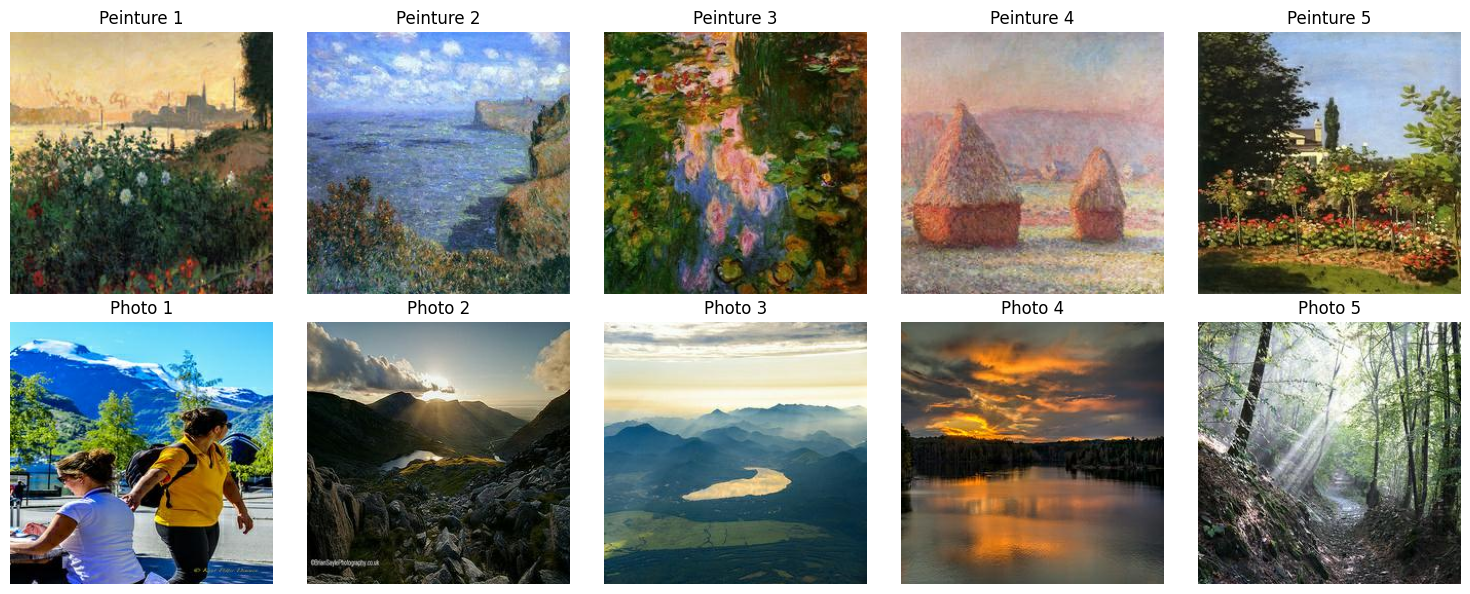

In [ ]:
# affichage echantillons
photos_folder = "/content/drive/MyDrive/gan-getting-started/photo_jpg"
paintings_folder = "/content/drive/MyDrive/gan-getting-started/monet_jpg"

n_images = 5

paintings = [f for f in os.listdir(paintings_folder) if f.endswith('.jpg')]
photos = [f for f in os.listdir(photos_folder) if f.endswith('.jpg')]

sample_paintings = random.sample(paintings, n_images)
sample_photos = random.sample(photos, n_images)

fig, axes = plt.subplots(nrows=2, ncols=n_images, figsize=(15, 6))

for i, painting_file in enumerate(sample_paintings):
    img = Image.open(os.path.join(paintings_folder, painting_file))
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Peinture {i+1}')

for i, photo_file in enumerate(sample_photos):
    img = Image.open(os.path.join(photos_folder, photo_file))
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Photo {i+1}')

plt.tight_layout()
plt.show()


In [ ]:
# chemins de sauvegardes
photo_statistics = "/content/drive/MyDrive/gan-getting-started/photo_statistics.csv"
painting_statistics = "/content/drive/MyDrive/gan-getting-started/painting_statistics.csv"

# chemins de nos photos et peintures
photos_folder = "/content/drive/MyDrive/gan-getting-started/photo_jpg"
paintings_folder = "/content/drive/MyDrive/gan-getting-started/monet_jpg"


In [ ]:
# Calcul stat si le csv n'existe pas deja
if not os.path.exists(photo_statistics) and not os.path.exists(painting_statistics):
  photo_stats = calculate_statistics(photos_folder)
  painting_stats = calculate_statistics(paintings_folder)

  print("Statistiques pour les photos:")
  print(photo_stats.head())
  print("\nStatistiques pour les peintures:")
  print(painting_stats.head())

  # Sauvegarder les statistiques dans des fichiers CSV
  photo_stats.to_csv(photo_statistics, index=False)
  painting_stats.to_csv(painting_statistics, index=False)


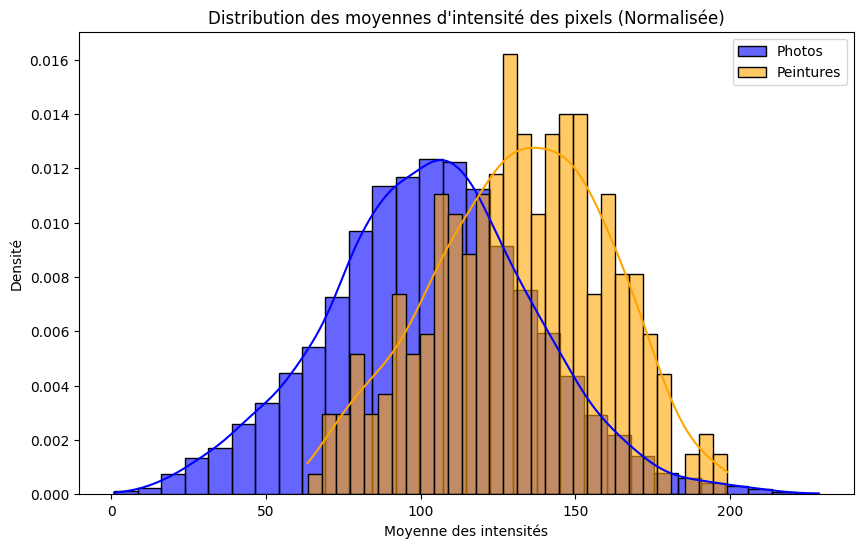

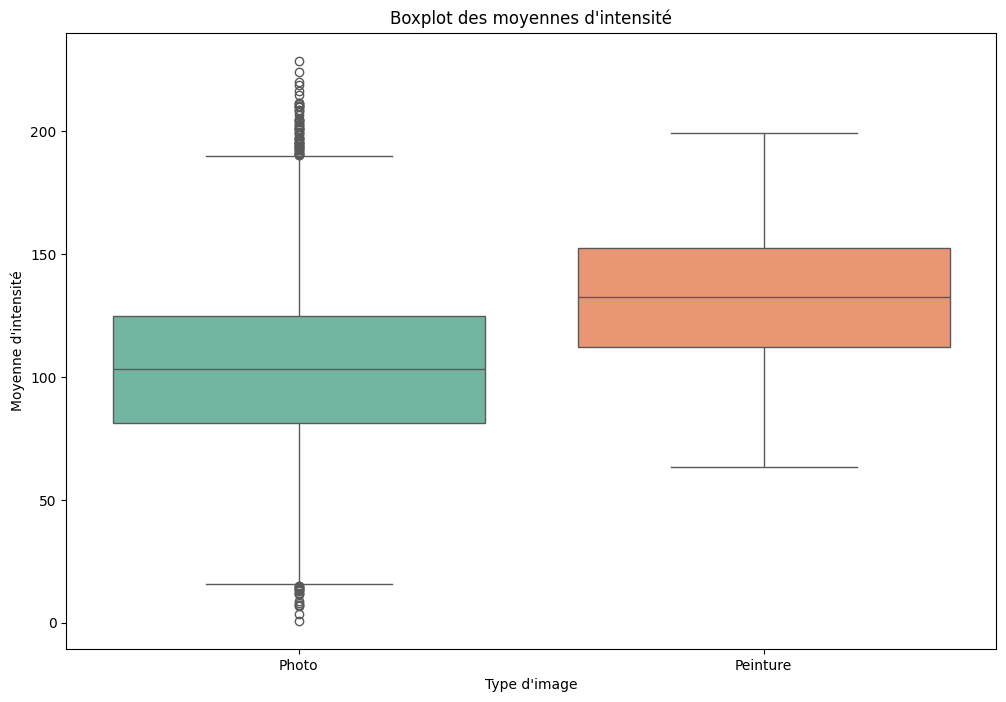

In [ ]:
# affichage statistiques (intensité)
photo_stats = pd.read_csv(photo_statistics)
painting_stats = pd.read_csv(painting_statistics)


def plot_from_csv(photo_stats, painting_stats):

    plt.figure(figsize=(10, 6))
    sns.histplot(photo_stats['mean'], bins=30, kde=True, color="blue", label="Photos", alpha=0.6, stat="density")
    sns.histplot(painting_stats['mean'], bins=30, kde=True, color="orange", label="Peintures", alpha=0.6, stat="density")
    plt.title("Distribution des moyennes d'intensité des pixels (Normalisée)")
    plt.xlabel("Moyenne des intensités")
    plt.ylabel("Densité")
    plt.legend()
    plt.show()


    combined_stats = photo_stats.copy()
    combined_stats['type'] = "Photo"
    painting_stats['type'] = "Peinture"
    combined_stats = pd.concat([combined_stats, painting_stats], ignore_index=True)

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='type', y='mean', data=combined_stats, palette="Set2")
    plt.title("Boxplot des moyennes d'intensité")
    plt.xlabel("Type d'image")
    plt.ylabel("Moyenne d'intensité")
    plt.show()

plot_from_csv(photo_stats, painting_stats)


outlier peut etre expliqué par les contres jour ou sur exposition

In [ ]:
# calcul des tailles de nos images
def get_image_sizes(image_folder):
    sizes = []
    for image_file in os.listdir(image_folder):
        if image_file.endswith('.jpg'):
            img = Image.open(os.path.join(image_folder, image_file))
            sizes.append(img.size)
    return np.array(sizes)


painting_sizes = get_image_sizes(paintings_folder)
photo_sizes = get_image_sizes(photos_folder)

# Statistiques sur les tailles
print("Peintures - Largeur: min =", painting_sizes[:, 0].min(), ", max =", painting_sizes[:, 0].max(), ", moyenne =", painting_sizes[:, 0].mean())
print("Peintures - Hauteur: min =", painting_sizes[:, 1].min(), ", max =", painting_sizes[:, 1].max(), ", moyenne =", painting_sizes[:, 1].mean())
print("Photos - Largeur: min =", photo_sizes[:, 0].min(), ", max =", photo_sizes[:, 0].max(), ", moyenne =", photo_sizes[:, 0].mean())
print("Photos - Hauteur: min =", photo_sizes[:, 1].min(), ", max =", photo_sizes[:, 1].max(), ", moyenne =", photo_sizes[:, 1].mean())


Peintures - Largeur: min = 256 , max = 256 , moyenne = 256.0
Peintures - Hauteur: min = 256 , max = 256 , moyenne = 256.0
Photos - Largeur: min = 256 , max = 256 , moyenne = 256.0
Photos - Hauteur: min = 256 , max = 256 , moyenne = 256.0


In [ ]:
# calcul des variances si le csv n'existe pas
save_file = "/content/drive/MyDrive/gan-getting-started/variances_et_moyennes.csv"


if not os.path.exists(save_file):

  painting_variances = get_color_variance(paintings_folder)
  photo_variances = get_color_variance(photos_folder)


  print(f"Nombre de peintures : {len(painting_variances)}")
  print(f"Nombre de photos : {len(photo_variances)}")


  max_length = len(photo_variances)
  painting_variances_padded = np.pad(painting_variances, ((0, max_length - len(painting_variances)), (0, 0)), mode='constant', constant_values=np.nan)


  painting_mean = painting_variances.mean(axis=0)
  photo_mean = photo_variances.mean(axis=0)

  data = {
      'Peinture_R': painting_variances_padded[:, 0],
      'Peinture_G': painting_variances_padded[:, 1],
      'Peinture_B': painting_variances_padded[:, 2],
      'Photos_R': photo_variances[:, 0],
      'Photos_G': photo_variances[:, 1],
      'Photos_B': photo_variances[:, 2],
      'Moyenne_R_Peintures': painting_mean[0],
      'Moyenne_G_Peintures': painting_mean[1],
      'Moyenne_B_Peintures': painting_mean[2],
      'Moyenne_R_Photos': photo_mean[0],
      'Moyenne_G_Photos': photo_mean[1],
      'Moyenne_B_Photos': photo_mean[2],
  }

  df = pd.DataFrame(data)


  df.to_csv(save_file, index=False)

  print(f"CSV sauvegardé dans {save_file}")


Nombre de peintures : 300
Nombre de photos : 7038
CSV sauvegardé dans /content/drive/MyDrive/gan-getting-started/variances_et_moyennes.csv


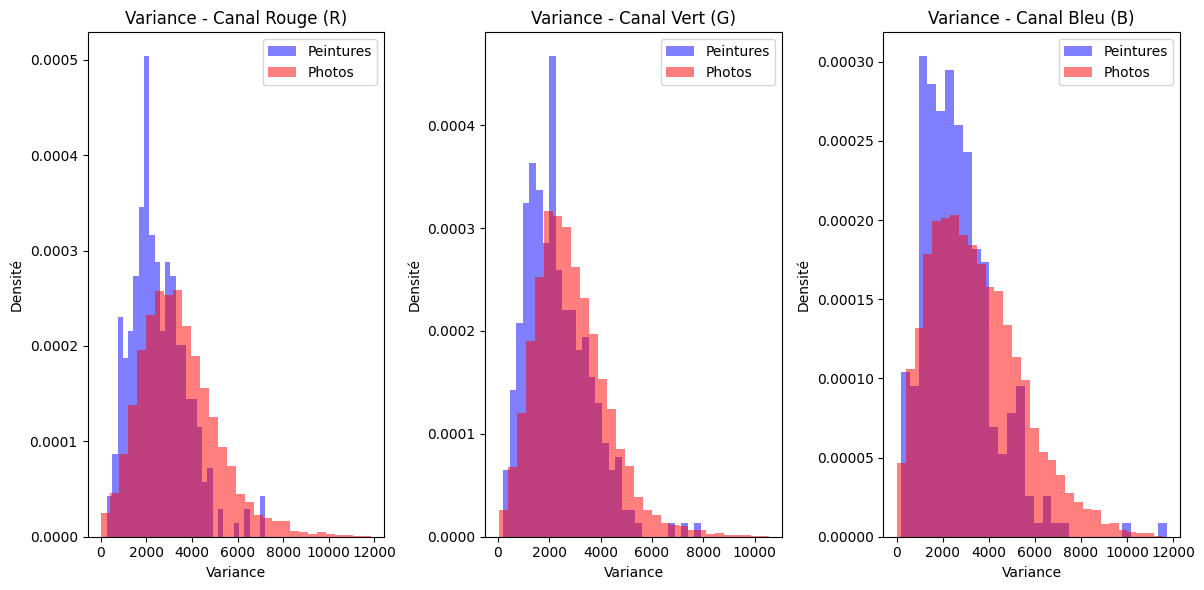

In [ ]:
# afficahge variance
df = pd.read_csv('/content/drive/MyDrive/gan-getting-started/variances_et_moyennes.csv')

plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 3, 1)
ax1.hist(df['Peinture_R'], bins=30, alpha=0.5, color='blue', label='Peintures', density=True)
ax1.hist(df['Photos_R'], bins=30, alpha=0.5, color='red', label='Photos', density=True)
ax1.set_title('Variance - Canal Rouge (R)')
ax1.set_xlabel('Variance')
ax1.set_ylabel('Densité')
ax1.legend(loc='upper right')

ax2 = plt.subplot(1, 3, 2)
ax2.hist(df['Peinture_G'], bins=30, alpha=0.5, color='blue', label='Peintures', density=True)
ax2.hist(df['Photos_G'], bins=30, alpha=0.5, color='red', label='Photos', density=True)
ax2.set_title('Variance - Canal Vert (G)')
ax2.set_xlabel('Variance')
ax2.set_ylabel('Densité')
ax2.legend(loc='upper right')

ax3 = plt.subplot(1, 3, 3)
ax3.hist(df['Peinture_B'], bins=30, alpha=0.5, color='blue', label='Peintures', density=True)
ax3.hist(df['Photos_B'], bins=30, alpha=0.5, color='red', label='Photos', density=True)
ax3.set_title('Variance - Canal Bleu (B)')
ax3.set_xlabel('Variance')
ax3.set_ylabel('Densité')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# calcul des contrastes si csv n'existe pas
save_file_contra = "/content/drive/MyDrive/gan-getting-started/contrast_values.csv"

if not os.path.exists(save_file_contra):


  painting_contrasts = get_contrasts(paintings_folder)
  photo_contrasts = get_contrasts(photos_folder)

  print(f"Nombre de peintures : {len(painting_contrasts)}")
  print(f"Nombre de photos : {len(photo_contrasts)}")


  max_length = max(len(painting_contrasts), len(photo_contrasts))
  painting_contrasts_padded = np.pad(painting_contrasts, (0, max_length - len(painting_contrasts)), mode='constant', constant_values=np.nan)
  photo_contrasts_padded = np.pad(photo_contrasts, (0, max_length - len(photo_contrasts)), mode='constant', constant_values=np.nan)

  print(f"Nombre de peintures après padding : {len(painting_contrasts_padded)}")
  print(f"Nombre de photos après padding : {len(photo_contrasts_padded)}")

  data = {
      'Contraste_Peintures': painting_contrasts_padded,
      'Contraste_Photos': photo_contrasts_padded,
  }


  df = pd.DataFrame(data)

  df.to_csv(save_file_contra, index=False)

  print(f"CSV sauvegardé dans {save_file_contra}")


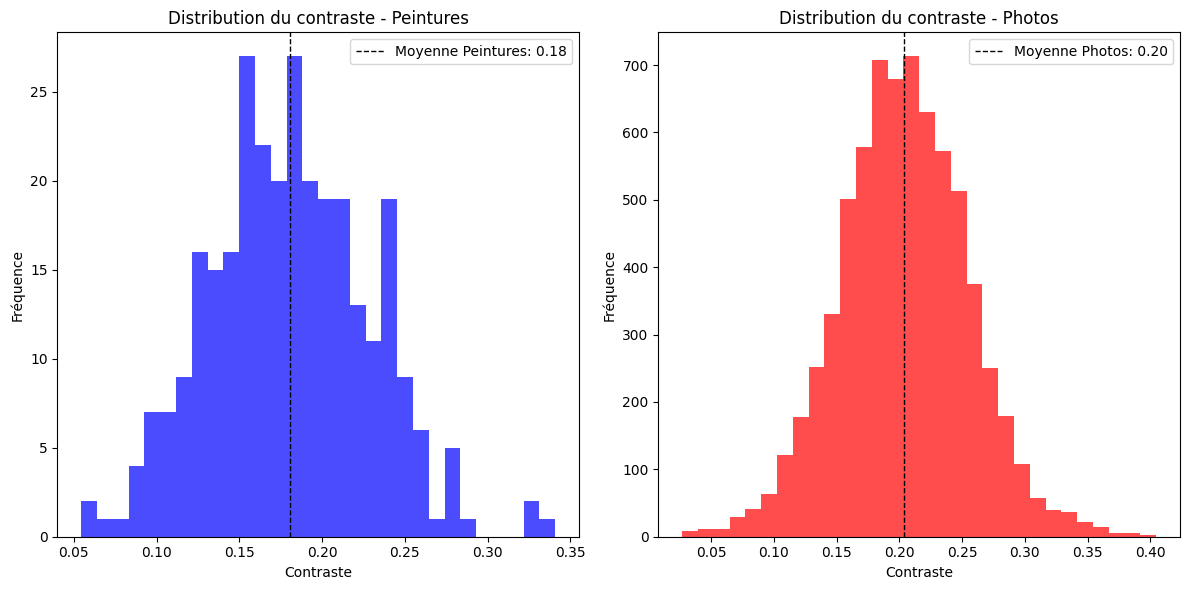

In [ ]:
# affichage contraste
csv_file = "/content/drive/MyDrive/gan-getting-started/contrast_values.csv"
df = pd.read_csv(csv_file)

mean_contrast_paintings = df['Contraste_Peintures'].dropna().mean()
mean_contrast_photos = df['Contraste_Photos'].dropna().mean()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['Contraste_Peintures'].dropna(), bins=30, color='blue', alpha=0.7)
plt.axvline(mean_contrast_paintings, color='black', linestyle='dashed', linewidth=1, label=f'Moyenne Peintures: {mean_contrast_paintings:.2f}')
plt.title('Distribution du contraste - Peintures')
plt.xlabel('Contraste')
plt.ylabel('Fréquence')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df['Contraste_Photos'].dropna(), bins=30, color='red', alpha=0.7)
plt.axvline(mean_contrast_photos, color='black', linestyle='dashed', linewidth=1, label=f'Moyenne Photos: {mean_contrast_photos:.2f}')
plt.title('Distribution du contraste - Photos')
plt.xlabel('Contraste')
plt.ylabel('Fréquence')
plt.legend()

plt.tight_layout()
plt.show()


Le code suivant permet de mettre de coté 300 photos, en effet après plusieurs tests, travailler avec les 2000 photos était trop gourmant. Nous avons donc décider de travailler avec 300 peintures et 300 photos.

In [ ]:
# import os
# import shutil

# # Définir le chemin vers le dossier contenant les images
# source_folder = "/content/drive/MyDrive/gan-getting-started/photo_jpg"  # Remplacez par le chemin réel de votre dossier
# destination_folder = "/content/drive/MyDrive/gan-getting-started/photo_jpg_filtered"  # Remplacez par le chemin réel de votre dossier de destination

# # Créez le dossier de destination s'il n'existe pas
# if not os.path.exists(destination_folder):
#     os.makedirs(destination_folder)

# # Listez tous les fichiers dans le dossier source
# all_files = os.listdir(source_folder)

# # Filtrez les fichiers .jpg
# jpg_files = [f for f in all_files if f.lower().endswith('.jpg')]

# # Prenez les 300 premières images
# first_300_images = jpg_files[:300]

# # Copiez chaque image dans le dossier de destination
# for image in first_300_images:
#     # Définir le chemin source et le chemin de destination
#     source_path = os.path.join(source_folder, image)
#     destination_path = os.path.join(destination_folder, image)

#     # Copier le fichier
#     shutil.copy(source_path, destination_path)

# print("300 premières images copiées avec succès.")


300 premières images copiées avec succès.


## Etude des données avec les 300 photos et non les 2000

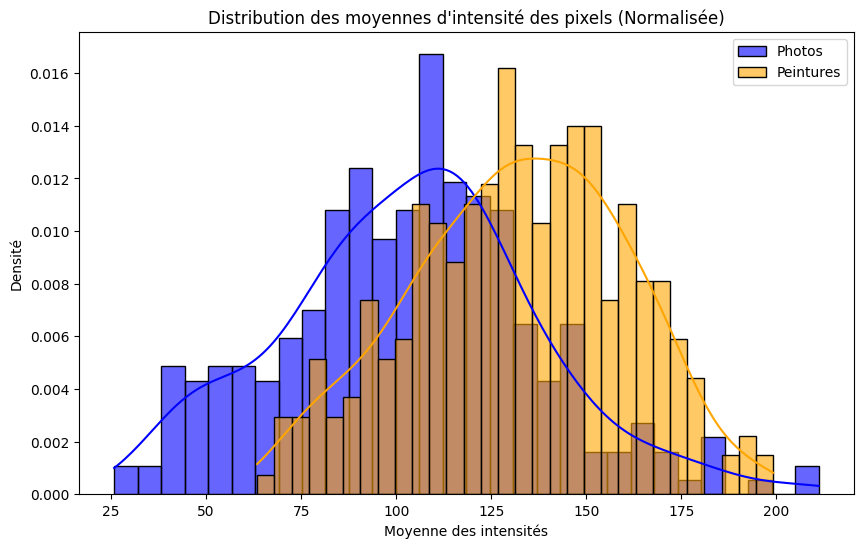

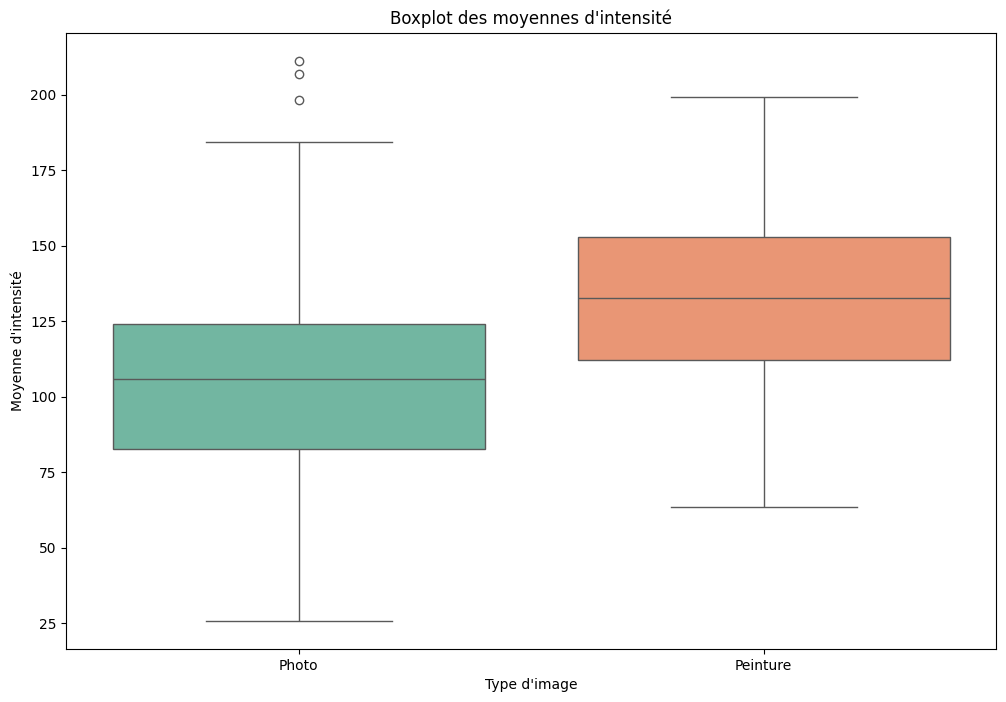

In [ ]:
photo_statistics_300 = "/content/drive/MyDrive/gan-getting-started/photo_statistics_300.csv"
painting_statistics_300 = "/content/drive/MyDrive/gan-getting-started/painting_statistics_300.csv"
photos_folder_300 = "/content/drive/MyDrive/gan-getting-started/photo_jpg_filtered"
paintings_folder_300 = "/content/drive/MyDrive/gan-getting-started/monet_jpg"

if not os.path.exists(photo_statistics_300) and not os.path.exists(painting_statistics_300):

  photo_stats = calculate_statistics(photos_folder_300)
  painting_stats = calculate_statistics(paintings_folder_300)

  print("Statistiques pour les photos:")
  print(photo_stats.head())
  print("\nStatistiques pour les peintures:")
  print(painting_stats.head())

  photo_stats.to_csv(photo_statistics_300, index=False)
  painting_stats.to_csv(painting_statistics_300, index=False)


photo_stats = pd.read_csv(photo_statistics_300)
painting_stats = pd.read_csv(painting_statistics_300)


def plot_from_csv(photo_stats, painting_stats):

    plt.figure(figsize=(10, 6))
    sns.histplot(photo_stats['mean'], bins=30, kde=True, color="blue", label="Photos", alpha=0.6, stat="density")
    sns.histplot(painting_stats['mean'], bins=30, kde=True, color="orange", label="Peintures", alpha=0.6, stat="density")
    plt.title("Distribution des moyennes d'intensité des pixels (Normalisée)")
    plt.xlabel("Moyenne des intensités")
    plt.ylabel("Densité")
    plt.legend()
    plt.show()


    combined_stats = photo_stats.copy()
    combined_stats['type'] = "Photo"
    painting_stats['type'] = "Peinture"
    combined_stats = pd.concat([combined_stats, painting_stats], ignore_index=True)

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='type', y='mean', data=combined_stats, palette="Set2")
    plt.title("Boxplot des moyennes d'intensité")
    plt.xlabel("Type d'image")
    plt.ylabel("Moyenne d'intensité")
    plt.show()

plot_from_csv(photo_stats, painting_stats)


In [ ]:
save_file_300 = "/content/drive/MyDrive/gan-getting-started/variances_et_moyennes_300.csv"


if not os.path.exists(save_file_300):

  painting_variances = get_color_variance(paintings_folder)
  photo_variances = get_color_variance(photos_folder)


  print(f"Nombre de peintures : {len(painting_variances)}")
  print(f"Nombre de photos : {len(photo_variances)}")


  max_length = len(photo_variances)
  painting_variances_padded = np.pad(painting_variances, ((0, max_length - len(painting_variances)), (0, 0)), mode='constant', constant_values=np.nan)


  painting_mean = painting_variances.mean(axis=0)
  photo_mean = photo_variances.mean(axis=0)

  data = {
      'Peinture_R': painting_variances_padded[:, 0],
      'Peinture_G': painting_variances_padded[:, 1],
      'Peinture_B': painting_variances_padded[:, 2],
      'Photos_R': photo_variances[:, 0],
      'Photos_G': photo_variances[:, 1],
      'Photos_B': photo_variances[:, 2],
      'Moyenne_R_Peintures': painting_mean[0],
      'Moyenne_G_Peintures': painting_mean[1],
      'Moyenne_B_Peintures': painting_mean[2],
      'Moyenne_R_Photos': photo_mean[0],
      'Moyenne_G_Photos': photo_mean[1],
      'Moyenne_B_Photos': photo_mean[2],
  }

  df = pd.DataFrame(data)


  df.to_csv(save_file_300, index=False)

  print(f"CSV sauvegardé dans {save_file_300}")


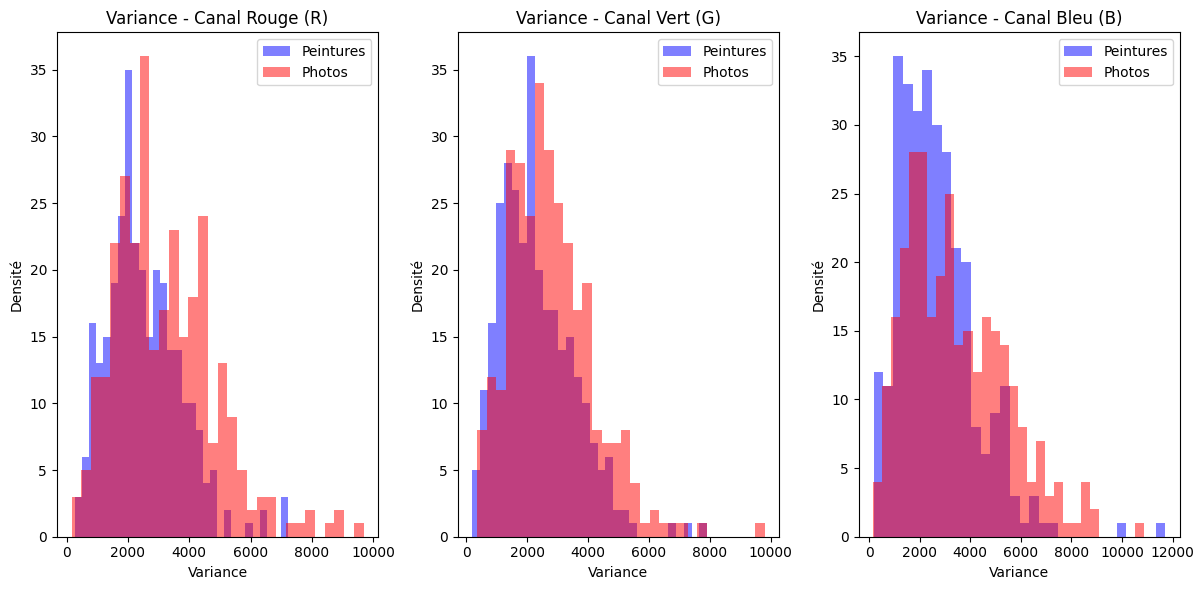

In [ ]:
df = pd.read_csv(save_file_300)

plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 3, 1)
ax1.hist(df['Peinture_R'], bins=30, alpha=0.5, color='blue', label='Peintures')
ax1.hist(df['Photos_R'], bins=30, alpha=0.5, color='red', label='Photos')
ax1.set_title('Variance - Canal Rouge (R)')
ax1.set_xlabel('Variance')
ax1.set_ylabel('Densité')
ax1.legend(loc='upper right')

ax2 = plt.subplot(1, 3, 2)
ax2.hist(df['Peinture_G'], bins=30, alpha=0.5, color='blue', label='Peintures')
ax2.hist(df['Photos_G'], bins=30, alpha=0.5, color='red', label='Photos')
ax2.set_title('Variance - Canal Vert (G)')
ax2.set_xlabel('Variance')
ax2.set_ylabel('Densité')
ax2.legend(loc='upper right')

ax3 = plt.subplot(1, 3, 3)
ax3.hist(df['Peinture_B'], bins=30, alpha=0.5, color='blue', label='Peintures')
ax3.hist(df['Photos_B'], bins=30, alpha=0.5, color='red', label='Photos')
ax3.set_title('Variance - Canal Bleu (B)')
ax3.set_xlabel('Variance')
ax3.set_ylabel('Densité')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
save_file_contra_300 = "/content/drive/MyDrive/gan-getting-started/contrast_values_300.csv"

if not os.path.exists(save_file_contra_300):

  painting_contrasts = get_contrasts(paintings_folder_300)
  photo_contrasts = get_contrasts(photos_folder_300)

  print(f"Nombre de peintures : {len(painting_contrasts)}")
  print(f"Nombre de photos : {len(photo_contrasts)}")


  max_length = max(len(painting_contrasts), len(photo_contrasts))
  painting_contrasts_padded = np.pad(painting_contrasts, (0, max_length - len(painting_contrasts)), mode='constant', constant_values=np.nan)
  photo_contrasts_padded = np.pad(photo_contrasts, (0, max_length - len(photo_contrasts)), mode='constant', constant_values=np.nan)

  print(f"Nombre de peintures après padding : {len(painting_contrasts_padded)}")
  print(f"Nombre de photos après padding : {len(photo_contrasts_padded)}")

  data = {
      'Contraste_Peintures': painting_contrasts_padded,
      'Contraste_Photos': photo_contrasts_padded,
  }


  df = pd.DataFrame(data)

  df.to_csv(save_file_contra_300, index=False)

  print(f"CSV sauvegardé dans {save_file_contra_300}")


Nombre de peintures : 300
Nombre de photos : 300
Nombre de peintures après padding : 300
Nombre de photos après padding : 300
CSV sauvegardé dans /content/drive/MyDrive/gan-getting-started/contrast_values_300.csv


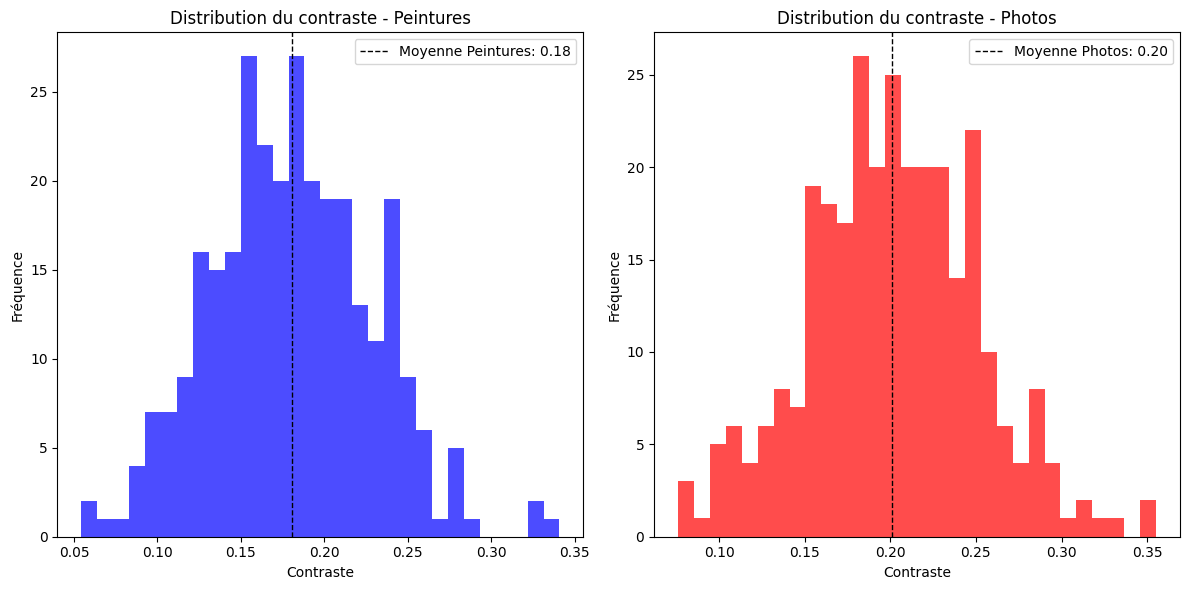

In [ ]:
df = pd.read_csv(save_file_contra_300)

mean_contrast_paintings = df['Contraste_Peintures'].dropna().mean()
mean_contrast_photos = df['Contraste_Photos'].dropna().mean()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['Contraste_Peintures'].dropna(), bins=30, color='blue', alpha=0.7)
plt.axvline(mean_contrast_paintings, color='black', linestyle='dashed', linewidth=1, label=f'Moyenne Peintures: {mean_contrast_paintings:.2f}')
plt.title('Distribution du contraste - Peintures')
plt.xlabel('Contraste')
plt.ylabel('Fréquence')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df['Contraste_Photos'].dropna(), bins=30, color='red', alpha=0.7)
plt.axvline(mean_contrast_photos, color='black', linestyle='dashed', linewidth=1, label=f'Moyenne Photos: {mean_contrast_photos:.2f}')
plt.title('Distribution du contraste - Photos')
plt.xlabel('Contraste')
plt.ylabel('Fréquence')
plt.legend()

plt.tight_layout()
plt.show()


## Création du modèle et entrainement

In [ ]:
# Création de dataloader afin d'utiliser la puisance de GPU avec Pytorch et cuda
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_images=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

        if max_images is not None:
            self.images = self.images[:max_images]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


photos_folder = "/content/drive/MyDrive/gan-getting-started/photo_jpg"
paintings_folder = "/content/drive/MyDrive/gan-getting-started/monet_jpg"


photo_dataset = ImageDataset(photos_folder, transform=transform,max_images=300)
painting_dataset = ImageDataset(paintings_folder, transform=transform)


photo_loader = DataLoader(photo_dataset, batch_size=8, shuffle=True)
painting_loader = DataLoader(painting_dataset, batch_size=8, shuffle=True)



In [ ]:
# Création de notre modèle Generateur de peinture
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Création de notre modèle disciminateur (deviner si c'est une vraie ou fausse peinture)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
      x = self.model(x)
      x = x.view(x.size(0), -1)
      x = x.mean(dim=1)
      return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00009, betas=(0.5, 0.999))

In [ ]:
# Entrainement
epochs = 100
d_losses = []
g_losses = []
for epoch in range(epochs):
    g_loss_epoch = 0.0
    d_loss_epoch = 0.0
    for photos, paintings in zip(photo_loader, cycle(painting_loader)):
        vraie_peinture = paintings.to(device)
        photos = photos.to(device)
        real_labels = torch.ones(vraie_peinture.size(0), device=device)
        fake_labels = torch.zeros(photos.size(0), device=device)

        # --- Entraînement du Discriminateur ---
        optimizer_D.zero_grad()
        outputs_vraie_peinture = discriminator(vraie_peinture)
        d_loss_real = criterion(outputs_vraie_peinture, real_labels)
        noise = photos.to(device)
        fake_peinture = generator(noise)
        outputs_fake_peinture = discriminator(fake_peinture.detach())

        d_loss_fake = criterion(outputs_fake_peinture, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # --- Entraînement du Générateur ---
        optimizer_G.zero_grad()
        outputs_fake_peinture2 = discriminator(fake_peinture)
        g_loss = criterion(outputs_fake_peinture2, real_labels)
        g_loss.backward()
        optimizer_G.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()
        d_losses.append(d_loss_epoch / len(photo_loader))
        g_losses.append(g_loss_epoch / len(photo_loader))


    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss_epoch/len(photo_loader):.4f}  G_loss: {g_loss_epoch/len(photo_loader):.4f}")


Epoch [1/100]  D_loss: 1.3688  G_loss: 0.7248
Epoch [2/100]  D_loss: 1.3117  G_loss: 0.7804
Epoch [3/100]  D_loss: 1.3408  G_loss: 0.7905
Epoch [4/100]  D_loss: 1.3644  G_loss: 0.7451
Epoch [5/100]  D_loss: 1.3804  G_loss: 0.7289
Epoch [6/100]  D_loss: 1.3606  G_loss: 0.7376
Epoch [7/100]  D_loss: 1.3659  G_loss: 0.7265
Epoch [8/100]  D_loss: 1.3722  G_loss: 0.7199
Epoch [9/100]  D_loss: 1.3602  G_loss: 0.7277
Epoch [10/100]  D_loss: 1.3671  G_loss: 0.7243
Epoch [11/100]  D_loss: 1.3661  G_loss: 0.7195
Epoch [12/100]  D_loss: 1.3547  G_loss: 0.7385
Epoch [13/100]  D_loss: 1.3600  G_loss: 0.7360
Epoch [14/100]  D_loss: 1.3634  G_loss: 0.7254
Epoch [15/100]  D_loss: 1.3587  G_loss: 0.7287
Epoch [16/100]  D_loss: 1.3533  G_loss: 0.7362
Epoch [17/100]  D_loss: 1.3823  G_loss: 0.7171
Epoch [18/100]  D_loss: 1.3552  G_loss: 0.7334
Epoch [19/100]  D_loss: 1.3503  G_loss: 0.7327
Epoch [20/100]  D_loss: 1.3534  G_loss: 0.7364
Epoch [21/100]  D_loss: 1.3596  G_loss: 0.7491
Epoch [22/100]  D_loss

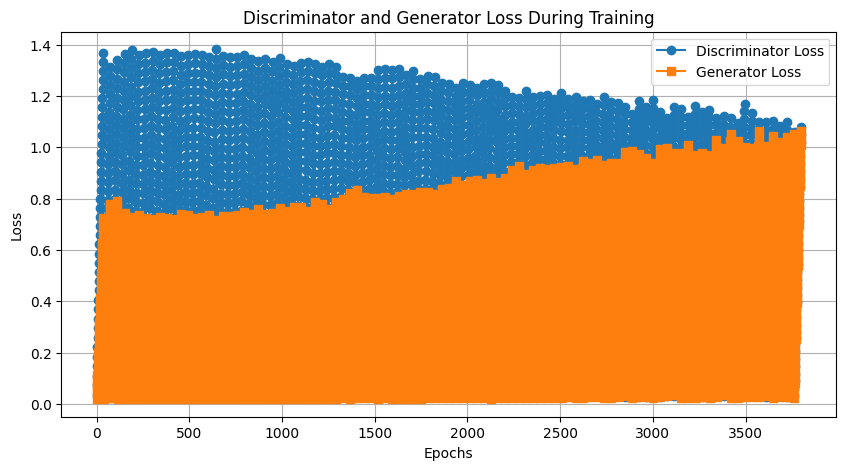

In [ ]:
# Visualisation de la loss de nos modèles
plt.figure(figsize=(10,5))
plt.plot(d_losses, marker='o', linestyle='-', label='Discriminator Loss')
plt.plot(g_losses, marker='s', linestyle='-', label='Generator Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Loss During Training')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

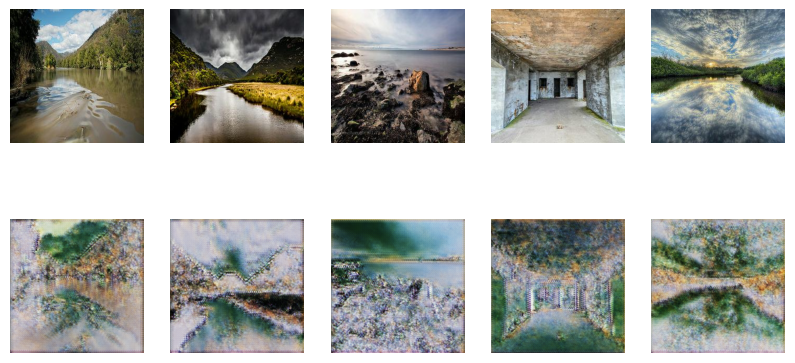

In [ ]:
generator.eval()
with torch.no_grad():
    for i, photos in enumerate(photo_loader):
        photos = photos.to(device)
        generated_images = generator(photos)
        plt.figure(figsize=(10, 5))
        for j in range(5):
            plt.subplot(2, 5, j+1)
            plt.imshow(photos[j].cpu().permute(1, 2, 0) * 0.5 + 0.5)
            plt.axis('off')
            plt.subplot(2, 5, j+6)
            plt.imshow(generated_images[j].cpu().permute(1, 2, 0) * 0.5 + 0.5)
            plt.axis('off')
        plt.show()
        if i == 0:
            break


In [ ]:
# Generation de nos 300 photos en 300 peinture grace à notre generateur
generator.eval()

output_dir = "/content/drive/MyDrive/gan-getting-started/fake_monet_jpg"
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for i, photos in enumerate(photo_loader):
        photos = photos.to(device)
        generated_images = generator(photos)

        for j in range(photos.size(0)):

            save_path = os.path.join(output_dir, f"image_{i * photos.size(0) + j:04d}.png")

            save_image(generated_images[j] * 0.5 + 0.5, save_path)

        print(f"Batch {i + 1}/{len(photo_loader)} processed...")

print("Toutes les images générées ont été sauvegardées dans:", output_dir)


Batch 1/38 processed...
Batch 2/38 processed...
Batch 3/38 processed...
Batch 4/38 processed...
Batch 5/38 processed...
Batch 6/38 processed...
Batch 7/38 processed...
Batch 8/38 processed...
Batch 9/38 processed...
Batch 10/38 processed...
Batch 11/38 processed...
Batch 12/38 processed...
Batch 13/38 processed...
Batch 14/38 processed...
Batch 15/38 processed...
Batch 16/38 processed...
Batch 17/38 processed...
Batch 18/38 processed...
Batch 19/38 processed...
Batch 20/38 processed...
Batch 21/38 processed...
Batch 22/38 processed...
Batch 23/38 processed...
Batch 24/38 processed...
Batch 25/38 processed...
Batch 26/38 processed...
Batch 27/38 processed...
Batch 28/38 processed...
Batch 29/38 processed...
Batch 30/38 processed...
Batch 31/38 processed...
Batch 32/38 processed...
Batch 33/38 processed...
Batch 34/38 processed...
Batch 35/38 processed...
Batch 36/38 processed...
Batch 37/38 processed...
Batch 38/38 processed...
Toutes les images générées ont été sauvegardées dans: /cont

# Conclusion des hypothèses

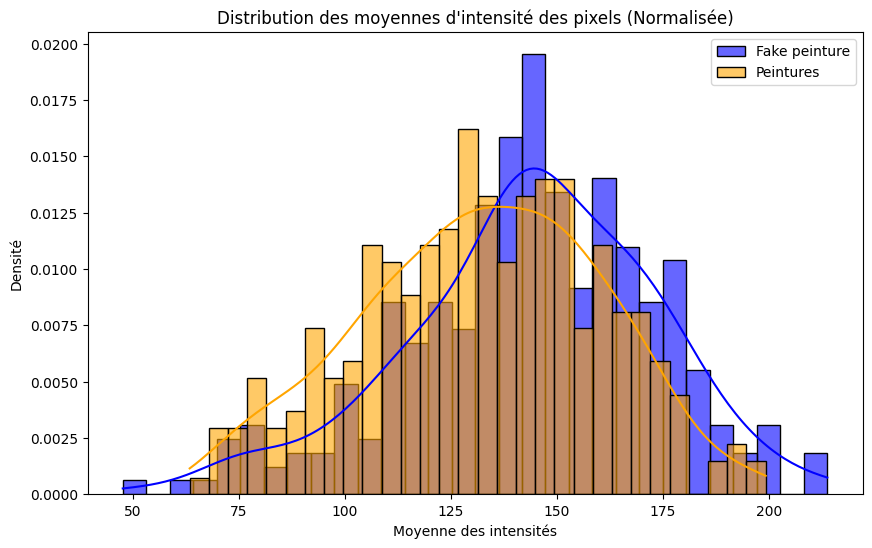

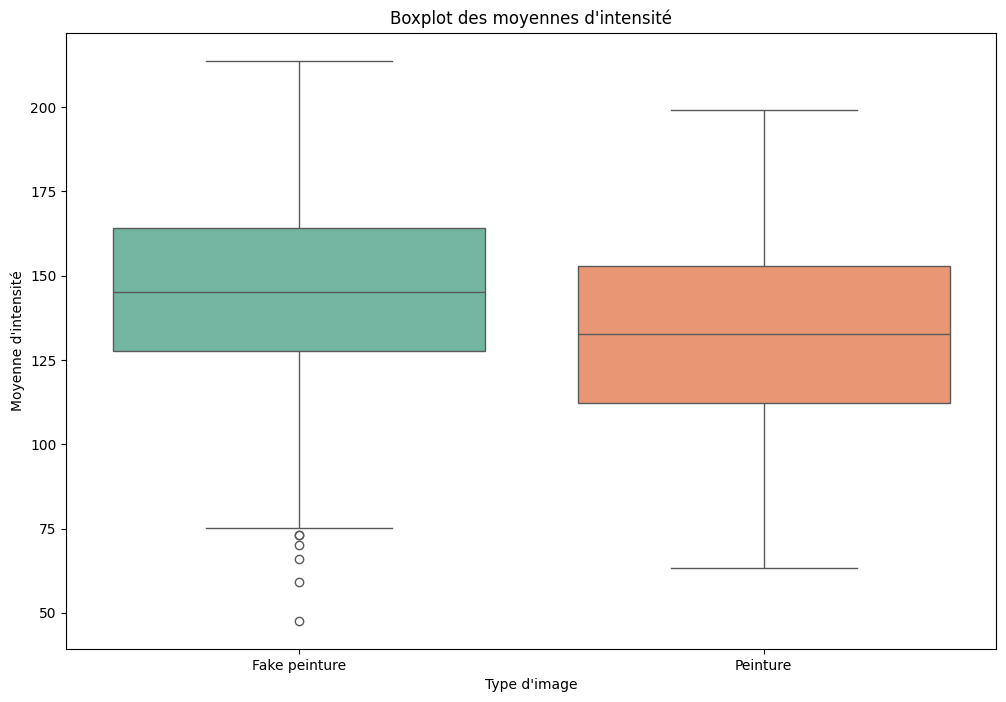

In [ ]:

photos_folder_FAKE = "/content/drive/MyDrive/gan-getting-started/fake_monet_jpg"
paintings_folder_300 = "/content/drive/MyDrive/gan-getting-started/monet_jpg"

fake_statistics = "/content/drive/MyDrive/gan-getting-started/photo_statistics_fake.csv"
no_fake_painting_statistics = "/content/drive/MyDrive/gan-getting-started/painting_statistics_300_no_fake.csv"

if not os.path.exists(fake_statistics) and not os.path.exists(no_fake_painting_statistics):


  photo_stats = calculate_statistics(photos_folder_FAKE)
  painting_stats = calculate_statistics(paintings_folder_300)

  print("Statistiques pour les photos:")
  print(photo_stats.head())
  print("\nStatistiques pour les peintures:")
  print(painting_stats.head())

  photo_stats.to_csv(fake_statistics, index=False)
  painting_stats.to_csv(no_fake_painting_statistics, index=False)


photo_stats = pd.read_csv(fake_statistics)
painting_stats = pd.read_csv(no_fake_painting_statistics)


def plot_from_csv(photo_stats, painting_stats):

    plt.figure(figsize=(10, 6))
    sns.histplot(photo_stats['mean'], bins=30, kde=True, color="blue", label="Fake peinture", alpha=0.6, stat="density")
    sns.histplot(painting_stats['mean'], bins=30, kde=True, color="orange", label="Peintures", alpha=0.6, stat="density")
    plt.title("Distribution des moyennes d'intensité des pixels (Normalisée)")
    plt.xlabel("Moyenne des intensités")
    plt.ylabel("Densité")
    plt.legend()
    plt.show()

    combined_stats = photo_stats.copy()
    combined_stats['type'] = "Fake peinture"
    painting_stats['type'] = "Peinture"
    combined_stats = pd.concat([combined_stats, painting_stats], ignore_index=True)

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='type', y='mean', data=combined_stats, palette="Set2")
    plt.title("Boxplot des moyennes d'intensité")
    plt.xlabel("Type d'image")
    plt.ylabel("Moyenne d'intensité")
    plt.show()


plot_from_csv(photo_stats, painting_stats)


In [ ]:
save_file_fake = "/content/drive/MyDrive/gan-getting-started/variances_et_moyennes_fake.csv"


if not os.path.exists(save_file_fake):

  painting_variances = get_color_variance(paintings_folder)
  photo_variances = get_color_variance(photos_folder_FAKE)


  print(f"Nombre de peintures : {len(painting_variances)}")
  print(f"Nombre de photos : {len(photo_variances)}")


  max_length = len(painting_variances)
  photo_variances_padded = np.pad(photo_variances, ((0, max_length - len(photo_variances)), (0, 0)), mode='constant', constant_values=np.nan)

  painting_mean = painting_variances.mean(axis=0)
  photo_mean = photo_variances.mean(axis=0)

  data = {
      'Peinture_R': painting_variances[:, 0],
      'Peinture_G': painting_variances[:, 1],
      'Peinture_B': painting_variances[:, 2],
      'Photos_R': photo_variances_padded[:, 0],
      'Photos_G': photo_variances_padded[:, 1],
      'Photos_B': photo_variances_padded[:, 2],
      'Moyenne_R_Peintures': painting_mean[0],
      'Moyenne_G_Peintures': painting_mean[1],
      'Moyenne_B_Peintures': painting_mean[2],
      'Moyenne_R_Photos': photo_mean[0],
      'Moyenne_G_Photos': photo_mean[1],
      'Moyenne_B_Photos': photo_mean[2],
  }

  df = pd.DataFrame(data)


  df.to_csv(save_file_fake, index=False)

  print(f"CSV sauvegardé dans {save_file_fake}")


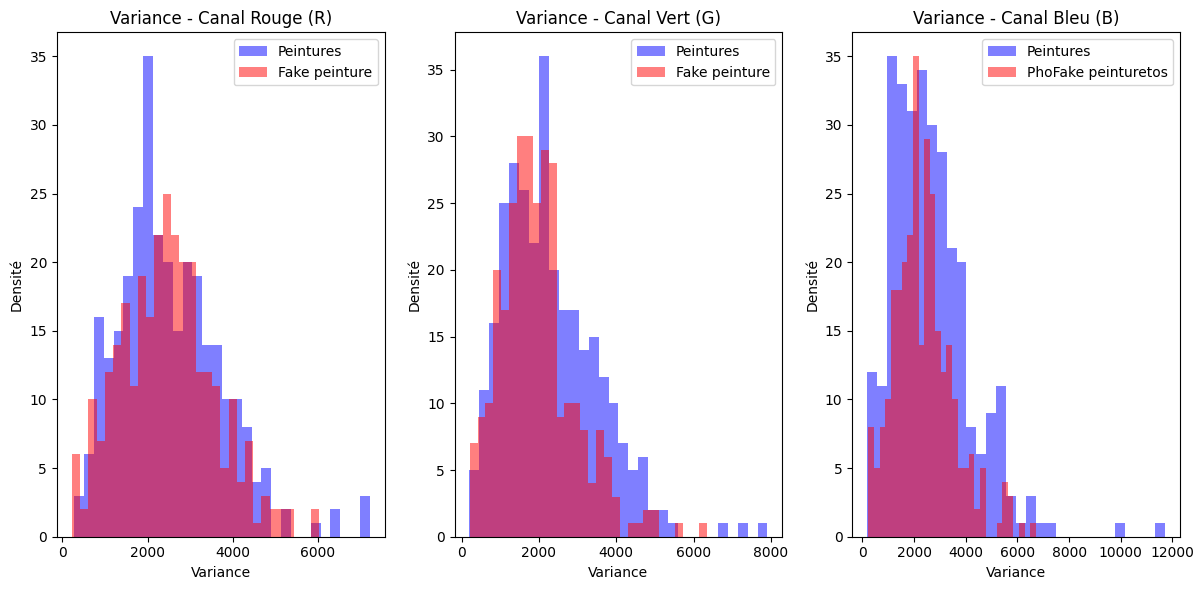

In [ ]:
df = pd.read_csv(save_file_fake)

plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 3, 1)
ax1.hist(df['Peinture_R'], bins=30, alpha=0.5, color='blue', label='Peintures')
ax1.hist(df['Photos_R'], bins=30, alpha=0.5, color='red', label='Fake peinture')
ax1.set_title('Variance - Canal Rouge (R)')
ax1.set_xlabel('Variance')
ax1.set_ylabel('Densité')
ax1.legend(loc='upper right')

ax2 = plt.subplot(1, 3, 2)
ax2.hist(df['Peinture_G'], bins=30, alpha=0.5, color='blue', label='Peintures')
ax2.hist(df['Photos_G'], bins=30, alpha=0.5, color='red', label='Fake peinture')
ax2.set_title('Variance - Canal Vert (G)')
ax2.set_xlabel('Variance')
ax2.set_ylabel('Densité')
ax2.legend(loc='upper right')

ax3 = plt.subplot(1, 3, 3)
ax3.hist(df['Peinture_B'], bins=30, alpha=0.5, color='blue', label='Peintures')
ax3.hist(df['Photos_B'], bins=30, alpha=0.5, color='red', label='PhoFake peinturetos')
ax3.set_title('Variance - Canal Bleu (B)')
ax3.set_xlabel('Variance')
ax3.set_ylabel('Densité')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
save_file_contra_fake = "/content/drive/MyDrive/gan-getting-started/contrast_values_fake.csv"

if not os.path.exists(save_file_contra_fake):
  # Calculer les contrastes pour les peintures et les photos
  painting_contrasts = get_contrasts(paintings_folder_300)
  photo_contrasts = get_contrasts(photos_folder_FAKE)

  print(f"Nombre de peintures : {len(painting_contrasts)}")
  print(f"Nombre de photos : {len(photo_contrasts)}")

  # Aligner les tailles des tableaux en ajoutant des NaN pour les peintures si nécessaire
  max_length = max(len(painting_contrasts), len(photo_contrasts))
  painting_contrasts_padded = np.pad(painting_contrasts, (0, max_length - len(painting_contrasts)), mode='constant', constant_values=np.nan)
  photo_contrasts_padded = np.pad(photo_contrasts, (0, max_length - len(photo_contrasts)), mode='constant', constant_values=np.nan)

  print(f"Nombre de peintures après padding : {len(painting_contrasts_padded)}")
  print(f"Nombre de photos après padding : {len(photo_contrasts_padded)}")

  data = {
      'Contraste_Peintures': painting_contrasts_padded,
      'Contraste_Photos': photo_contrasts_padded,
  }


  df = pd.DataFrame(data)

  df.to_csv(save_file_contra_fake, index=False)

  print(f"CSV sauvegardé dans {save_file_contra_fake}")


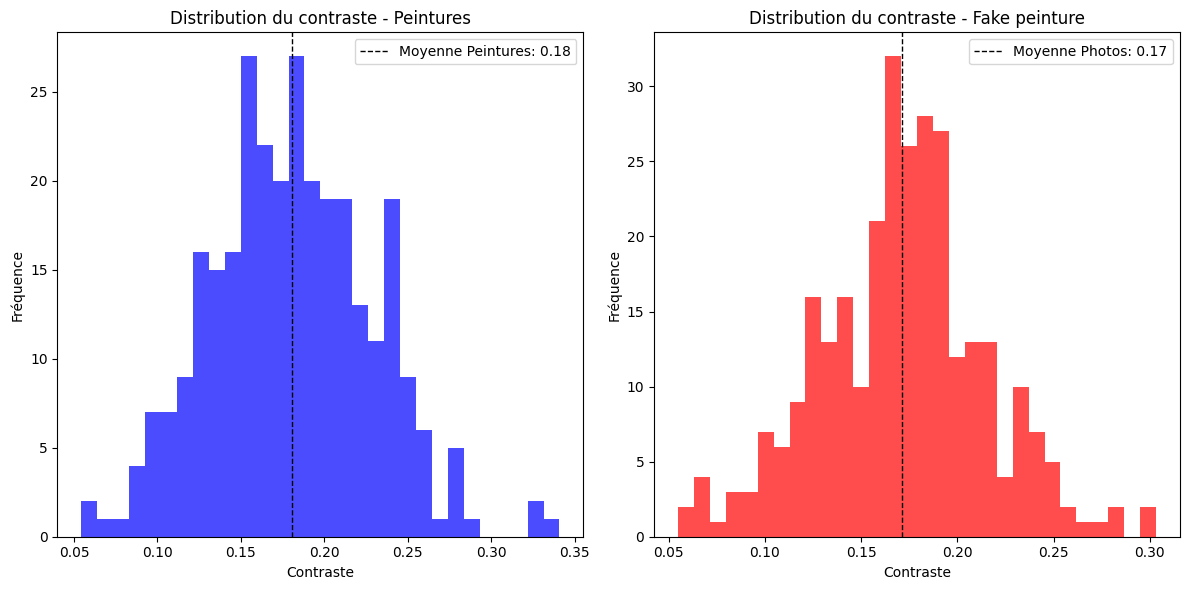

In [ ]:
df = pd.read_csv(save_file_contra_fake)

mean_contrast_paintings = df['Contraste_Peintures'].dropna().mean()
mean_contrast_photos = df['Contraste_Photos'].dropna().mean()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['Contraste_Peintures'].dropna(), bins=30, color='blue', alpha=0.7)
plt.axvline(mean_contrast_paintings, color='black', linestyle='dashed', linewidth=1, label=f'Moyenne Peintures: {mean_contrast_paintings:.2f}')
plt.title('Distribution du contraste - Peintures')
plt.xlabel('Contraste')
plt.ylabel('Fréquence')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(df['Contraste_Photos'].dropna(), bins=30, color='red', alpha=0.7)
plt.axvline(mean_contrast_photos, color='black', linestyle='dashed', linewidth=1, label=f'Moyenne Photos: {mean_contrast_photos:.2f}')
plt.title('Distribution du contraste - Fake peinture')
plt.xlabel('Contraste')
plt.ylabel('Fréquence')
plt.legend()

plt.tight_layout()
plt.show()


Les distributions de nos photos pour la variance et le contraste nous semblaient plus élevées. Maintenant si nous comparons avec nos fausses peintures, on aperçoit des distribution nettement plus proches avec des moyenne presque identique pour le contraste. Nous pouvons donc conclure que notre modèle a réussi à transformer nos photos pour ressembler à des peintures du style de Monet.
